# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/pyNBA/venv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.8.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Data Analysis
Summarize the characteristics of the dataset.

In [2]:
query_data = QueryData()
clean_data = CleanData()
helpers = Helpers()

# pull boxscore data
boxscores = query_data.query_boxscore_data()
boxscores = clean_data.select_regular_season_games(boxscores)
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [3]:
boxscores['POSSESSIONS'] = boxscores['PACE'] * (boxscores['SECONDSPLAYED']/(48*60))
grouped_team_boxscores = boxscores.groupby(['SEASON', 'DATE', 'TEAM', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_POSSESSIONS': x['POSSESSIONS'].sum()/5,
        'TEAM_DREB': x['DREB'].sum(),
        'TEAM_OREB': x['OREB'].sum()
    })
).reset_index()

grouped_opp_team_boxscores = grouped_team_boxscores.drop(columns='OPP_TEAM')
grouped_opp_team_boxscores = grouped_opp_team_boxscores.rename(columns={'TEAM': 'OPP_TEAM', 'TEAM_POSSESSIONS': 'OPP_TEAM_POSSESSIONS', 'TEAM_DREB': 'OPP_TEAM_DREB', 'TEAM_OREB': 'OPP_TEAM_OREB'})
team_reb_by_game = grouped_team_boxscores.merge(grouped_opp_team_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

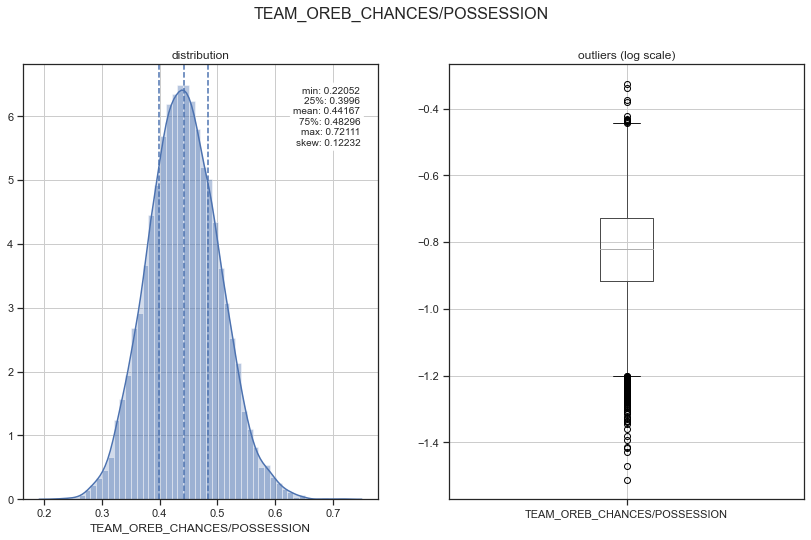

In [4]:
team_reb_by_game['TEAM_OREB_CHANCES'] = team_reb_by_game['TEAM_DREB'] + team_reb_by_game['OPP_TEAM_OREB']
team_reb_by_game['TEAM_OREB_CHANCES/POSSESSION'] = team_reb_by_game['TEAM_OREB_CHANCES']/team_reb_by_game['TEAM_POSSESSIONS']
helpers.visualize_variable_distribution(team_reb_by_game, 'TEAM_OREB_CHANCES/POSSESSION', figsize=(14, 8))

In [5]:
boxscores = boxscores.merge(team_reb_by_game, on=['SEASON', 'DATE', 'TEAM', 'OPP_TEAM'])
boxscores['OREB_CHANCES'] = np.nan
boxscores.loc[boxscores['OREB'] > 0, 'OREB_CHANCES'] = (boxscores.loc[boxscores['OREB'] > 0, 'OREB']/boxscores.loc[boxscores['OREB'] > 0, 'OREB_PCT']).apply(lambda x: round(x))
boxscores.loc[boxscores['OREB'] == 0, 'OREB_CHANCES'] = boxscores.loc[boxscores['OREB'] == 0, 'TEAM_OREB_CHANCES/POSSESSION']*boxscores.loc[boxscores['OREB'] == 0, 'POSSESSIONS']
boxscores['OREB/OREB_CHANCE'] = boxscores['OREB']/boxscores['OREB_CHANCES']

In [6]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='OREB/OREB_CHANCE', new_col_name='AVG_OREB/OREB_CHANCE',
    weight_col_name='OREB_CHANCES'
)

In [7]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

grouped_defensive_boxscores = boxscores.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_POSITION_OREB': x['OREB'].sum(),
        'TEAM_POSITION_OREB_CHANCES': x['OREB_CHANCES'].sum()
    })
).reset_index()

grouped_defensive_boxscores['OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED'] = grouped_defensive_boxscores['TEAM_POSITION_OREB']/grouped_defensive_boxscores['TEAM_POSITION_OREB_CHANCES']
grouped_defensive_boxscores = feature_creation.expanding_weighted_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'NORM_POS', 'OPP_TEAM'], col_name='OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED', new_col_name='AVG_OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED',
    weight_col_name='TEAM_POSITION_OREB_CHANCES', min_periods=3
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM'], how='left')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'NORM_POS', 'PLAYERID'], col_name='AVG_OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED', new_col_name='AVG_OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED_PLAYED_AGAINST',
    weight_col_name='OREB_CHANCES'
)

boxscores['OREB/OREB_CHANCE_DEF_ADJ'] = boxscores['AVG_OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED'] - boxscores['AVG_OPP_TEAM_POSITION_OREB/OREB_CHANCE_ALLOWED_PLAYED_AGAINST']

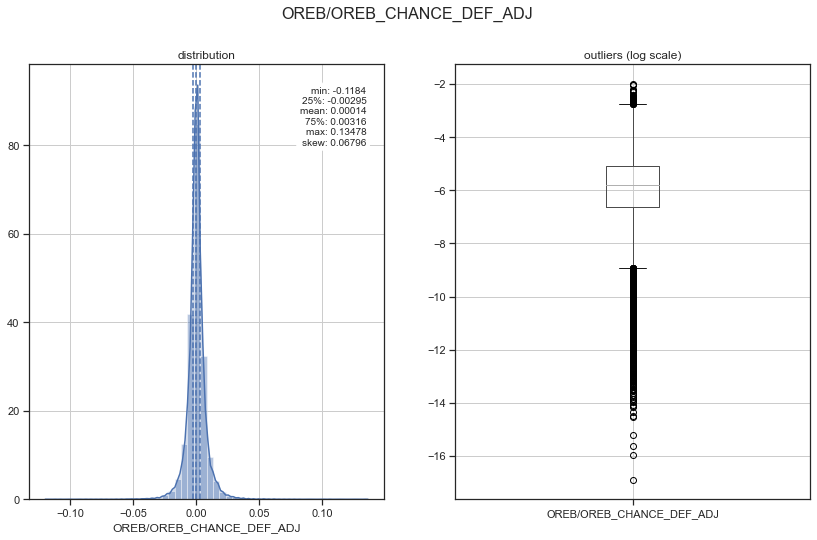

In [8]:
helpers.visualize_variable_distribution(boxscores, 'OREB/OREB_CHANCE_DEF_ADJ', figsize=(14, 8))
boxscores['OREB/OREB_CHANCE_DEF_ADJ'] = boxscores['OREB/OREB_CHANCE_DEF_ADJ'].fillna(0)

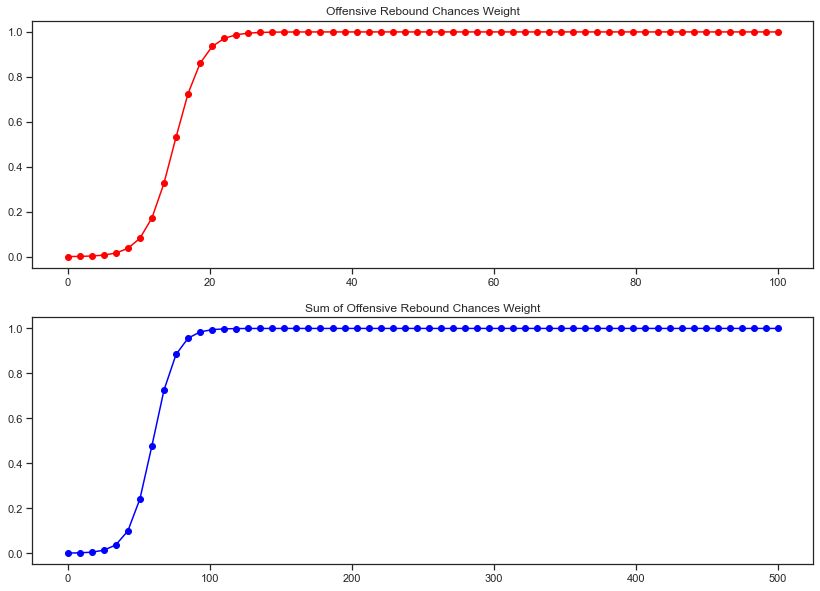

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-1*x + 15)/2))
sp_in_array = np.linspace(0, 100, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-1*x + 60)/8))
tsp_in_array = np.linspace(0, 500, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Offensive Rebound Chances Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Offensive Rebound Chances Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show()

boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='OREB_CHANCES', new_col_name='SUM_OREB_CHANCES'
)

w = 'WEIGHT'
boxscores[w] = boxscores['OREB_CHANCES'].apply(sp_weight_func) * boxscores['SUM_OREB_CHANCES'].apply(tsp_weight_func)

In [10]:
y = 'OREB/OREB_CHANCE'
selected_features = ['AVG_OREB/OREB_CHANCE', 'OREB/OREB_CHANCE_DEF_ADJ']

sig_boxscores = boxscores.loc[(boxscores['OREB_CHANCES'] > 10) & (boxscores['SUM_OREB_CHANCES'] > 50)]
feature_matrix = sig_boxscores.dropna(subset=selected_features)

X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

model = linear_model.LinearRegression()
model.fit(X_train, y_train, sample_weight=w_train)
print(model.coef_)

y_hat = model.predict(X_test)

[0.91849072 0.2466648 ]


In [11]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_OREB/OREB_CHANCE']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.349
Baseline: 0.344

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.031142
Baseline: 0.031098

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.041781
Baseline: 0.04192


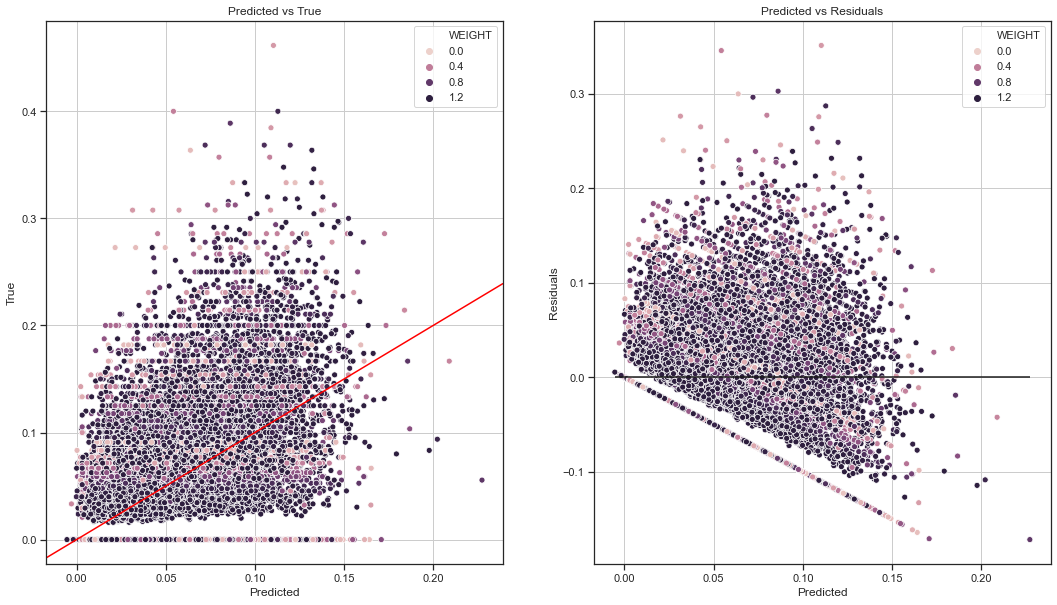

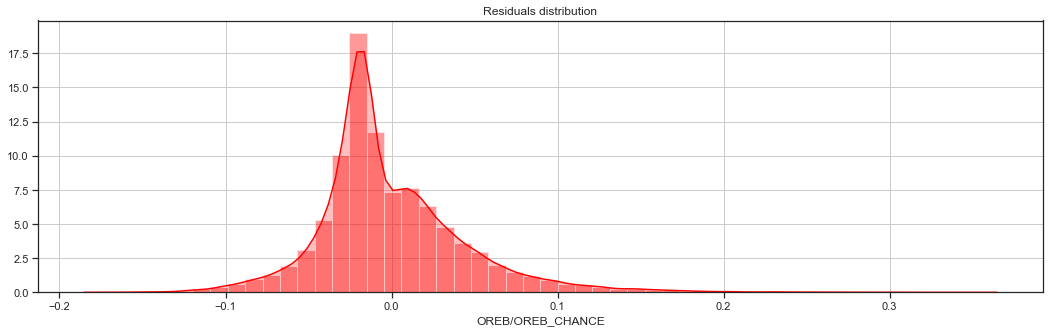

In [12]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [13]:
feature_matrix['{}_HAT'.format(y)] = model.predict(feature_matrix[selected_features])
display(feature_matrix[['SEASON', 'DATE', 'NAME', 'NORM_POS', 'TEAM', 'OPP_TEAM', 'OREB', 'POSSESSIONS', 'OREB_CHANCES'] + selected_features + [y, '{}_HAT'.format(y)]].tail(20))

,SEASON,DATE,NAME,NORM_POS,TEAM,OPP_TEAM,OREB,POSSESSIONS,OREB_CHANCES,AVG_OREB/OREB_CHANCE,OREB/OREB_CHANCE_DEF_ADJ,OREB/OREB_CHANCE,OREB/OREB_CHANCE_HAT
173792,2019-20,2020-03-11,Langston Galloway,Guard,DET,PHI,1,55.497208,29.000000,0.020073,-0.001054,0.034483,0.021307
173793,2019-20,2020-03-11,Christian Wood,Forward,DET,PHI,1,78.500479,40.000000,0.081550,-0.007353,0.025000,0.076220
173794,2019-20,2020-03-11,Thon Maker,Forward,DET,PHI,2,29.501667,15.000000,0.068873,-0.007996,0.133333,0.064417
173795,2019-20,2020-03-11,Brandon Knight,Guard,DET,PHI,1,67.998000,34.000000,0.000000,-0.001136,0.029412,0.002850
173796,2019-20,2020-03-11,Andre Iguodala,Guard,MIA,CHA,0,36.000191,16.310797,0.040185,0.001140,0.000000,0.040321
173798,2019-20,2020-03-11,Goran Dragic,Guard,MIA,CHA,1,51.498281,28.000000,0.017095,0.001357,0.035714,0.019167
173799,2019-20,2020-03-11,Duncan Robinson,Forward,MIA,CHA,0,65.988927,29.897952,0.005006,0.004079,0.000000,0.008734
173800,2019-20,2020-03-11,Kendrick Nunn,Guard,MIA,CHA,1,59.488479,26.000000,0.010672,0.001071,0.038462,0.013196
173804,2019-20,2020-03-11,Jae Crowder,Forward,MIA,CHA,2,60.002326,34.000000,0.017731,0.005209,0.058824,0.020701
173806,2019-20,2020-03-11,Solomon Hill,Forward,MIA,CHA,1,47.016667,22.000000,0.030394,0.003087,0.045455,0.031809
